# 0. 라이브러리 및 데이터 불러오기

* 240529_03_hr.ipynb 참고

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve       

import xgboost
from xgboost import XGBClassifier

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import random

In [2]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("xgboost", xgboost.__version__)
print("tensorflow: ", tensorflow.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
xgboost 2.0.3
tensorflow:  2.10.0


In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# breast_cancer

* 0: 악성
* 1: 양성

In [4]:
cancer = load_breast_cancer()

x_data = cancer["data"]
y_data = cancer["target"]

x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

In [5]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
y_train:  (455,)
x_test:  (114, 30)
y_test:  (114,)


In [7]:
np.unique(y_data, return_counts=True)

(array([0, 1]), array([212, 357], dtype=int64))

## RFC

* 240528_03_RF.ipynb 참고

In [6]:
rfc_best = RandomForestClassifier(n_estimators = 300, 
                               oob_score = True,
                               random_state = 209,
                               max_depth = None, 
                               max_features = 'sqrt', 
                               min_samples_leaf = 5,
                               min_samples_split = 4)

rfc_best.fit(x_train, y_train)
pred_rfc = rfc_best.predict(x_test)
print('The accuracy of the RFC is', 
      metrics.accuracy_score(pred_rfc, y_test))

The accuracy of the RFC is 0.956140350877193


## XGBoost

* 240529_02_boosting.ipynb 참고

In [8]:
xgb_best = XGBClassifier(booster = "gbtree", 
                         objective = "binary:logistic",
                         learning_rate = 0.09, 
                         max_depth = 3,
                         n_estimators = 220)

xgb_best.fit(x_train, y_train)
pred_xgb = xgb_best.predict(x_test)
print('The accuracy of the XGBoost is', 
      metrics.accuracy_score(pred_xgb, y_test))

The accuracy of the XGBoost is 0.9473684210526315


## DNN

* 240530_04_dnn.ipynb

In [9]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 30
# 출력노드 수
output_node = 1
# 은닉층 노드 수
first_hidden_node = 10

#모델
dnn = Sequential(name = "cancer_classifier")
dnn.add(Dense(first_hidden_node,
                 # kernel_initializer='he_normal',
                 activation = "relu", 
                 input_shape=(input_node,)
                ))
dnn.add(Dense(output_node, 
                 # kernel_initializer='he_normal',
                 activation = "sigmoid"
                ))

In [10]:
adam = Adam(learning_rate=0.01)

dnn.compile(loss='binary_crossentropy',
               optimizer=adam,
               metrics = ['accuracy'])

In [11]:
dnn_hist = dnn.fit(x_train, 
                         y_train,
                         epochs=10, 
                         batch_size=10, 
                         validation_split=0.2,
                         verbose = 0
                        )

In [12]:
pred_dnn = dnn.predict(x_test).flatten() >= 0.5
print('The accuracy of the DNN is', 
      metrics.accuracy_score(pred_dnn, y_test))

4/4 [==============================] - 0s 2ms/step
The accuracy of the DNN is 0.9736842105263158


**테스트 데이터에 대한 정확도**

|model| ACC|
|:---|---:|
|RFC GridSearchCV| 0.956|
|XGBoost GridSearchCV| 0.947|
|DNN| 0.973|

<img src="../img/240531_03.png" width = "500">

In [13]:
confusion_matrix(y_test, pred_rfc)

array([[39,  3],
       [ 2, 70]], dtype=int64)

In [17]:
metrics.precision_score(y_test, pred_rfc)

0.958904109589041

In [18]:
metrics.precision_score(pred_rfc, y_test)

0.9722222222222222

In [19]:
70/(70+3)

0.958904109589041

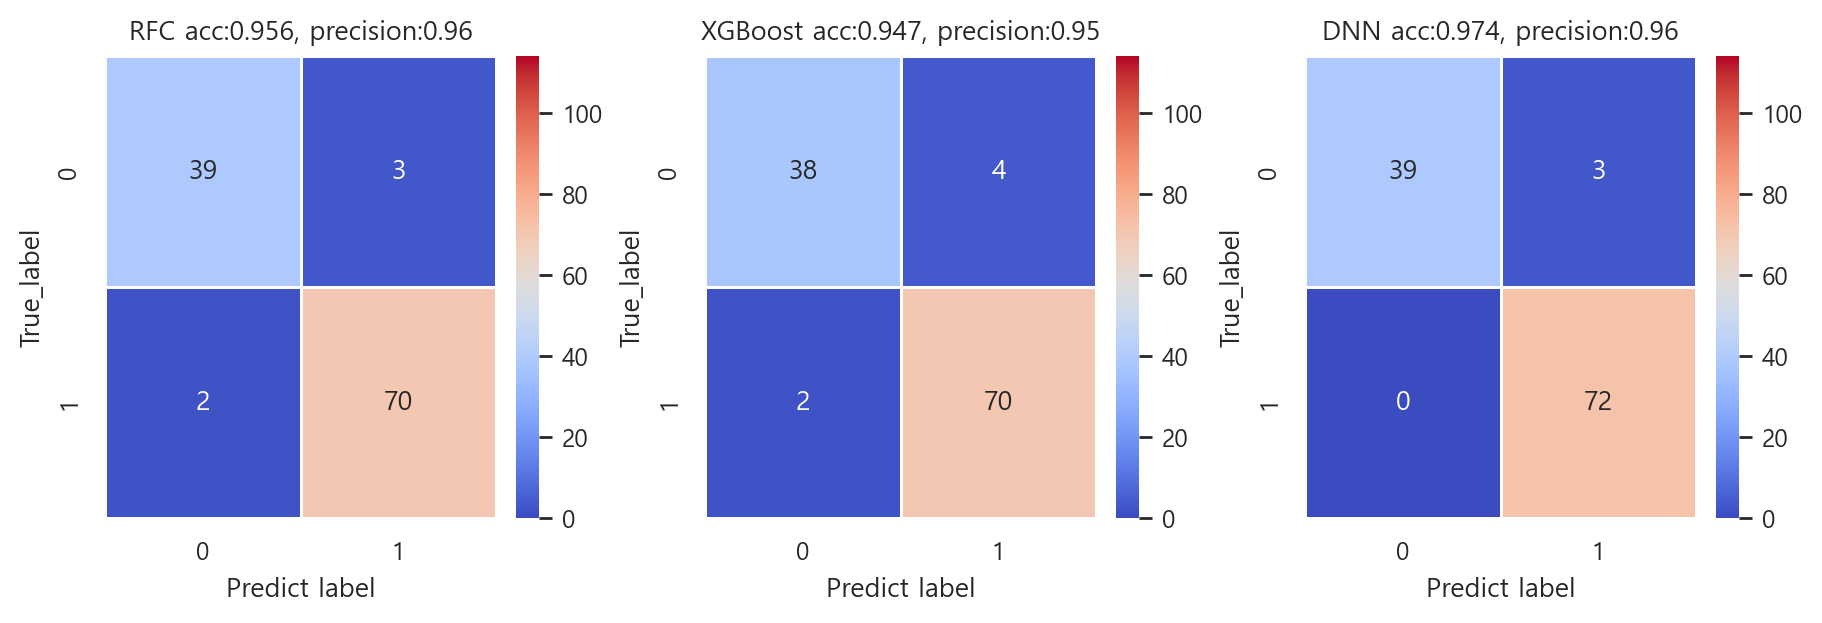

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

pred_dict = {"RFC": pred_rfc,
             "XGBoost": pred_xgb,
             "DNN": pred_dnn
            }

for name, ax in zip(pred_dict.keys(), axes.flat):
    matrix = pred_dict[name]
    acc = round(metrics.accuracy_score(pred_dict[name], y_test), 3)
    precision = round(metrics.precision_score(y_test, pred_dict[name]), 2)
    
    sns.heatmap(data = confusion_matrix(y_test, matrix), 
                cmap = "coolwarm",
                linecolor="white",
                linewidth=1,
                annot=True,
                vmax = 114,
                vmin = 0,
                ax=ax)
    title = f"{name} acc:{acc}, precision:{precision}"
    ax.set(xlabel = "Predict label", ylabel = "True_label", title = title)

# HR 데이터 

* 240529_03_hr.ipynb 참고

* no(재직): 0
* yes(퇴직): 1

In [20]:
train = pd.read_csv("../data/hr_train_scaling.csv",
                    index_col = 0)

test = pd.read_csv("../data/hr_test_scaling.csv",
                    index_col = 0)

In [21]:
x_train = train[train.columns[:-1]].values
y_train = train["attrition"].values

x_test = test[test.columns[:-1]].values
y_test = test["attrition"].values

In [22]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (1094, 12)
y_train:  (1094,)
x_test:  (365, 12)
y_test:  (365,)


## k-NN

In [23]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)
print('The accuracy of the KNN is', metrics.accuracy_score(pred_knn, y_test))

The accuracy of the KNN is 0.8328767123287671


## DT

In [24]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print('The accuracy of the DT is', metrics.accuracy_score(pred_tree, y_test))

The accuracy of the DT is 0.7671232876712328


## RFC

In [25]:
rfc_best = RandomForestClassifier(n_estimators = 200, 
                               oob_score = True,
                               random_state = 209,
                               max_depth = 3, 
                               max_features = None, 
                               min_samples_leaf = 7,
                               min_samples_split = 6)

rfc_best.fit(x_train, y_train)
pred_rfc = rfc_best.predict(x_test)
print('The accuracy of the RFC is', 
      metrics.accuracy_score(pred_rfc, y_test))

The accuracy of the RFC is 0.8273972602739726


## XGBoost

In [26]:
xgb_best = XGBClassifier(booster = "gbtree", 
                    objective = "binary:logistic",
                    learning_rate = 0.0301, 
                    max_depth = 3, 
                    n_estimators = 250)

xgb_best.fit(x_train, y_train)
pred_xgb = xgb_best.predict(x_test)
print('The accuracy of the XGBoost is', 
      metrics.accuracy_score(pred_xgb, y_test))

The accuracy of the XGBoost is 0.8301369863013699


## 신경망

In [27]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 12
# 출력노드 수
output_node = 1

#모델
dnn = Sequential(name = "hr_classifier")
dnn.add(Dense(output_node,
              kernel_initializer='he_normal',
              activation = "sigmoid",
              input_shape=(input_node,)
             ))

In [28]:
adam = Adam(learning_rate=0.0005)

dnn.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics = ['accuracy'])

# validation loss가 연속 3번 감소하지 않으면 조기종료
early_stopping = EarlyStopping(patience = 3,
                               restore_best_weights=True)

In [29]:
dnn_hist = dnn.fit(x_train, 
                   y_train,
                   epochs=40, 
                   batch_size=16, 
                   validation_split=0.2,
                   callbacks=[early_stopping]
                  )

Epoch 1/40
55/55 [==============================] - 2s 12ms/step - loss: 0.9397 - accuracy: 0.3166 - val_loss: 0.8510 - val_accuracy: 0.4018
Epoch 2/40
55/55 [==============================] - 0s 4ms/step - loss: 0.8738 - accuracy: 0.3326 - val_loss: 0.7979 - val_accuracy: 0.4155
Epoch 3/40
55/55 [==============================] - 0s 5ms/step - loss: 0.8150 - accuracy: 0.3726 - val_loss: 0.7513 - val_accuracy: 0.4475
Epoch 4/40
55/55 [==============================] - 0s 5ms/step - loss: 0.7625 - accuracy: 0.4103 - val_loss: 0.7107 - val_accuracy: 0.4658
Epoch 5/40
55/55 [==============================] - 0s 6ms/step - loss: 0.7160 - accuracy: 0.4549 - val_loss: 0.6750 - val_accuracy: 0.5023
Epoch 6/40
55/55 [==============================] - 0s 8ms/step - loss: 0.6748 - accuracy: 0.5154 - val_loss: 0.6444 - val_accuracy: 0.5434
Epoch 7/40
55/55 [==============================] - 0s 7ms/step - loss: 0.6390 - accuracy: 0.5886 - val_loss: 0.6182 - val_accuracy: 0.6393
Epoch 8/40
55/55 [=

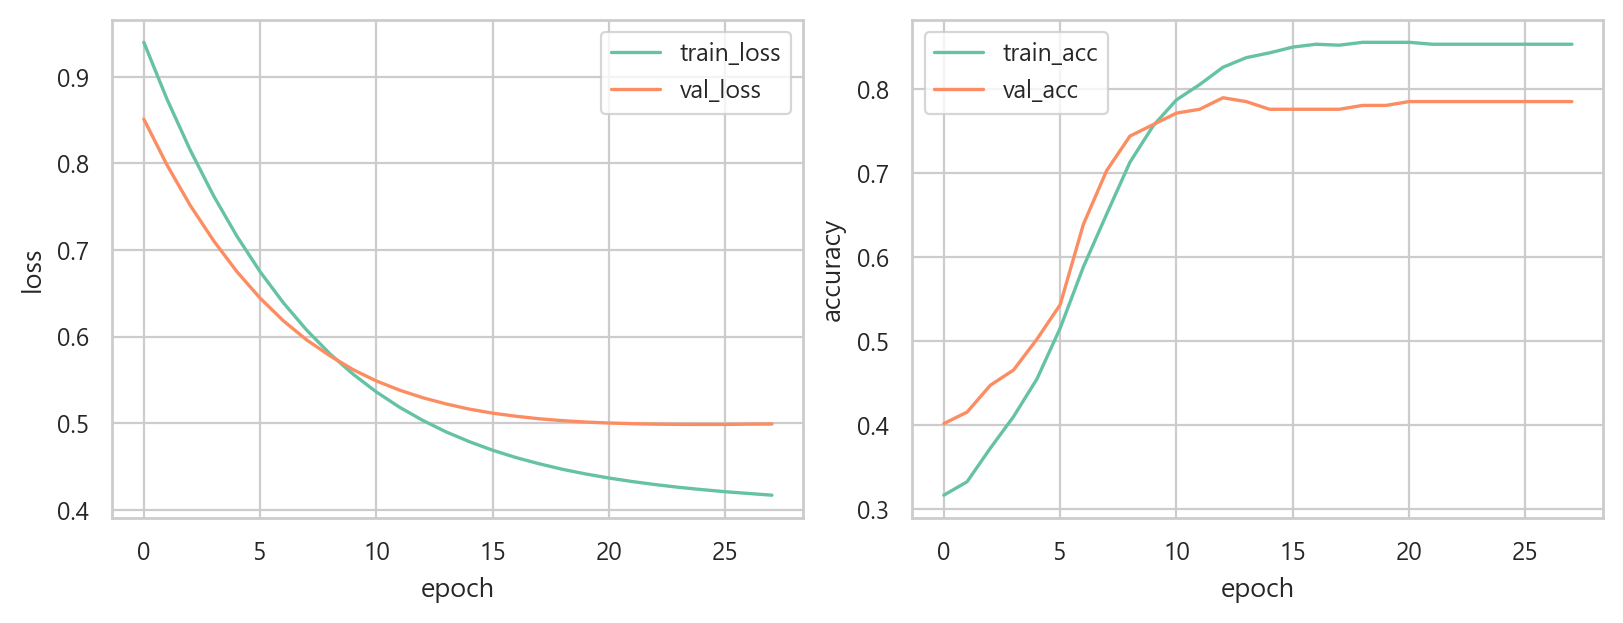

In [30]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(dnn_hist.history["loss"], label="train_loss")
ax_loss.plot(dnn_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch", ylabel = "loss")
ax_loss.legend()

ax_acc.plot(dnn_hist.history["accuracy"], label="train_acc")
ax_acc.plot(dnn_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch", ylabel = "accuracy")
ax_acc.legend();

In [36]:
dnn.predict(x_test).flatten() >= 0.5

12/12 [==============================] - 0s 2ms/step


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [40]:
pred_dnn = dnn.predict(x_test).flatten() >= 0.5
print('The accuracy of the ANN is', 
      metrics.accuracy_score(pred_dnn, y_test))

12/12 [==============================] - 0s 2ms/step
The accuracy of the ANN is 0.8383561643835616


**테스트 데이터에 대한 정확도**

|model| ACC|
|:---|---:|
|k-NN| 0.833|
|DT| 0.767|
|RFC GridSearchCV| 0.827|
|XGBoost GridSearchCV| 0.830|
|ANN| 0.838|

<img src="../img/240531_03.png" width = "500">

In [41]:
confusion_matrix(y_test, pred_rfc)

array([[298,   8],
       [ 55,   4]], dtype=int64)

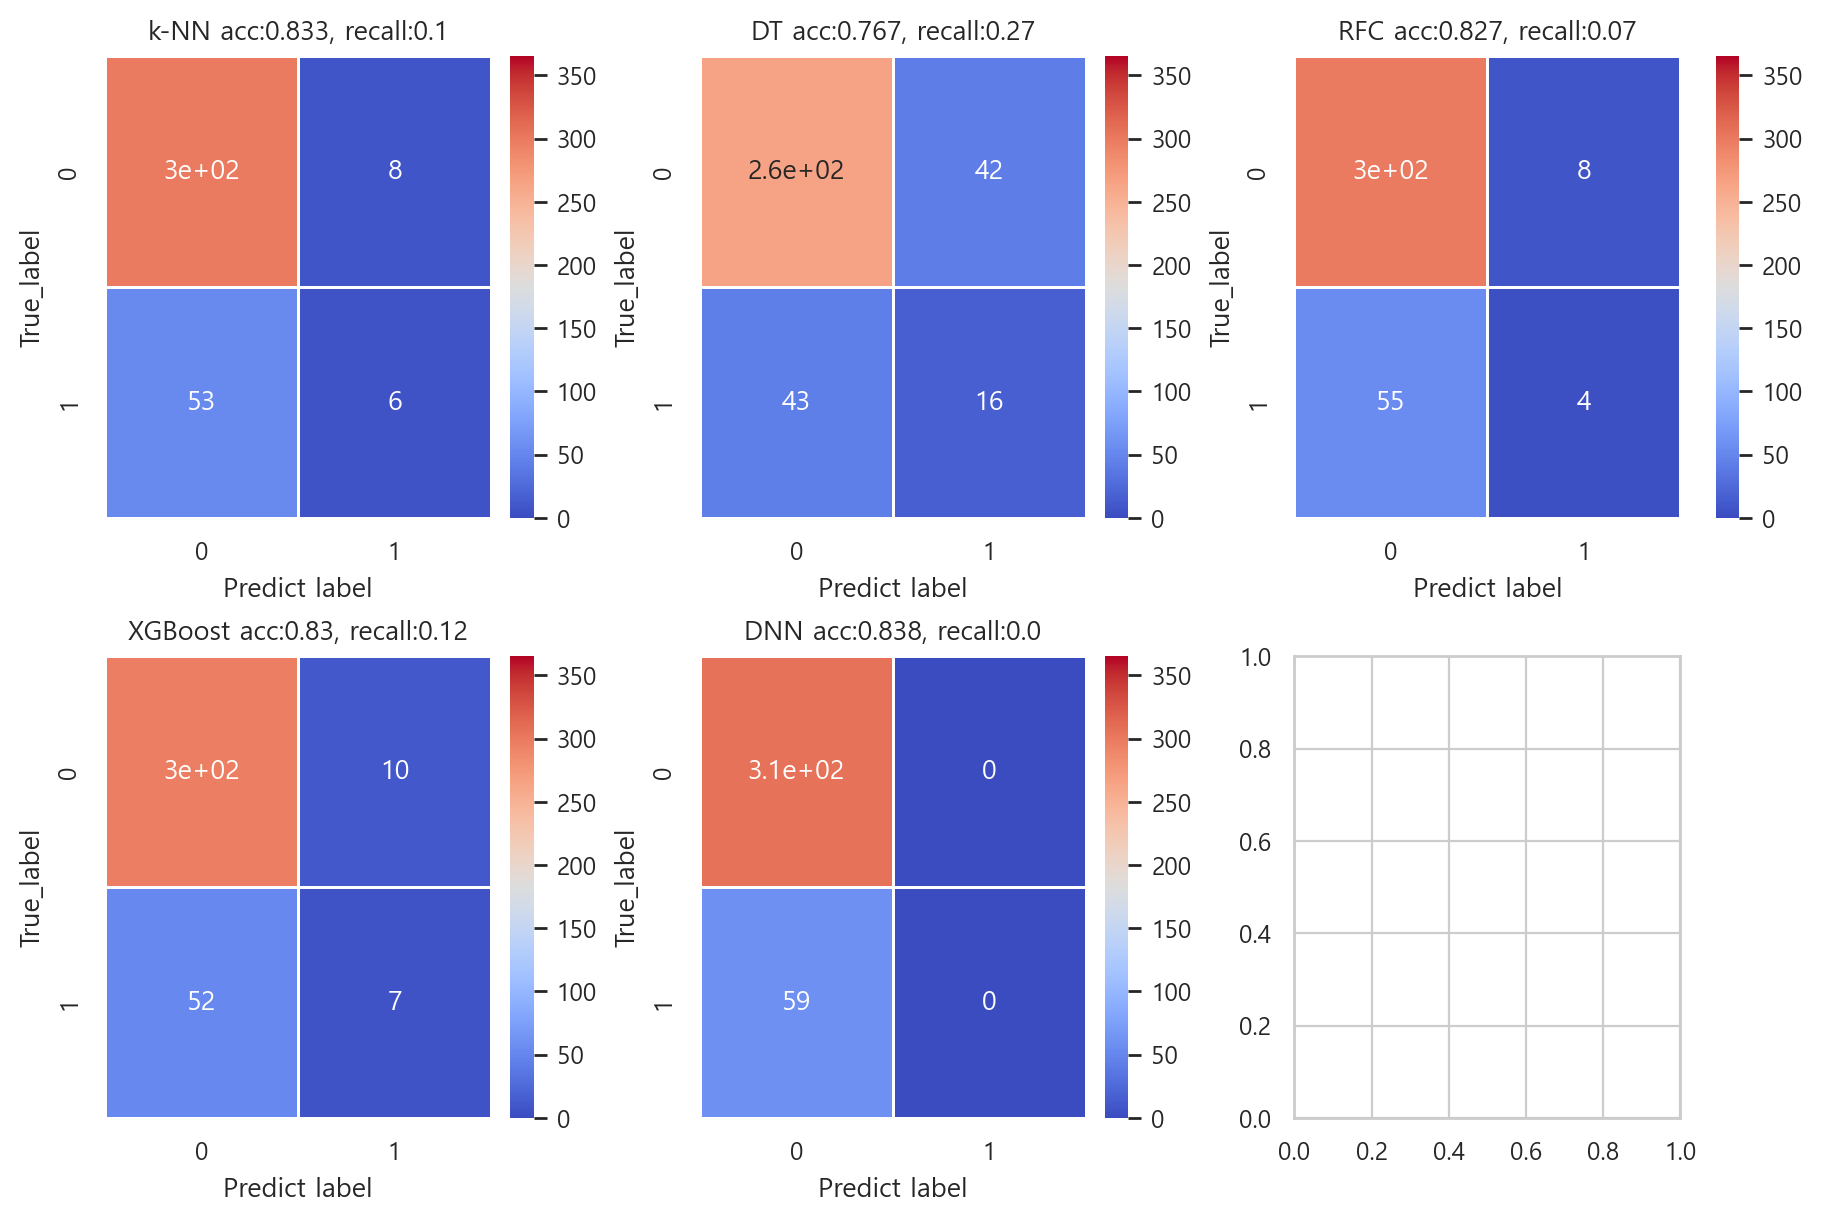

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(9,6))

pred_dict = {"k-NN": pred_knn,  # 추가
             "DT": pred_tree,   # 추가
             "RFC": pred_rfc,
             "XGBoost": pred_xgb,
             "DNN": pred_dnn
            }

for name, ax in zip(pred_dict.keys(), axes.flat):
    matrix = pred_dict[name]
    acc = round(metrics.accuracy_score(pred_dict[name], y_test), 3)
    recall = round(metrics.recall_score(y_test, pred_dict[name]), 2) #변경
    
    sns.heatmap(data = confusion_matrix(y_test, matrix), 
                cmap = "coolwarm",
                linecolor="white",
                linewidth=1,
                annot=True,
                vmax = 365, #변경
                vmin = 0,
                ax=ax)
    title = f"{name} acc:{acc}, recall:{recall}" #변경
    ax.set(xlabel = "Predict label", ylabel = "True_label", title = title)

# 3. Classification Report

In [43]:
confusion_matrix(y_test, pred_tree)

array([[264,  42],
       [ 43,  16]], dtype=int64)

In [44]:
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       306
           1       0.28      0.27      0.27        59

    accuracy                           0.77       365
   macro avg       0.57      0.57      0.57       365
weighted avg       0.77      0.77      0.77       365



* 평균에는 산술, 기하, 조화 평균이 있고, "평균"이라고 하면 일반적으로 산술 평균

* Let ${\bf{x}} = (x_1, x_2, \ldots, x_n)$ be a vector for $x_i\in\mathbb{R}$.

    * 산술평균(arithmetic mean) 
\begin{equation}
A({\bf{x}}) = \frac{\sum_{i=1}^nx_i}{n}
\end{equation}
    * 기하평균(geometric mean)   
\begin{equation}
G({\bf{x}}) = \left(\prod_{i=1}^nx_i\right)^{\frac{1}{n}}
\end{equation}
    * 조화평균(harmonic mean)   
\begin{equation}
H({\bf{x}}) = \frac{n}{\sum_{i=1}^n\frac{1}{x_i}}
\end{equation}

* 조화평균: 상대적인 비를 갖는 단위의 평균을 계산하는데 유용하게 사용
    * 예: 평균 속력을 계산할 때 사용 

* f1-score: precision과 recall의 조화평균으로 계산
\begin{equation}
\text{f1-score} = 2\frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}}.
\end{equation}

* f1-score는 데이터 불균형에서 모델을 평가할 때 사용
    * Decision Tree는 recall의 값도 0.27로 낮지만 f1-score의 값도 낮음